In [48]:
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from sbpy.data import Ephem, Phys
from sbpy.activity import (Haser, LTE, photo_timescale, einstein_coeff, 
intensity_conversion, beta_factor, total_number_nocd)
import matplotlib.pyplot as plt

LTE Production Rate without Photodissociation Effects
=============================
________________________________________________________________________________

`sbpy.spectroscopy` provides several models to calculate molecular production rates in comets. One of these models is based on the following paper:

> [Drahus et al. September 2012. The Sources of HCN and CH3OH and the
> Rotational Temperature in Comet 103P/Hartley 2 from Time-resolved
> Millimeter Spectroscopy. The Astrophysical Journal, Volume 756,
> Issue 1.](https://arxiv.org/abs/1202.3194)

This model does not include photodissociation effects. For details on the model parameters that are optional or needed for all the sbpy.activity functions used in these examples refer to the Reference/API section of the [documentation](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#module-sbpy.activity), or look at the simple examples [given here](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#production-rate-calculations). This extremely simplified model is useful to calculate first guesses for more computationally intensive Non-LTE models or for LTE Haser models that include photodissociation.

The following examples test this simple version of the production rate calculation. The calculations below are based and compared against results published in Drahus et al. 2012.

____________________________________________________________________________________________________________________

LTE `from_Drahus` First Example:
-------------------------------------------------------------------------------------------------------------

*Load the data file containing values for time of observations, integrated flux, 
and error bars from the literature (Drahus et al. 2012) in order to obtain the 
information needed for the calculation of our production rates*

In [49]:
hcn = Table.read('data/HCN.csv', format="ascii.csv") 

*Model parameters needed, all values are taken directly from the literature (Drahus et al. 2012). See [documentation](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#module-sbpy.activity) for the complete explanation of the parameters listed.*

In [50]:
temp_estimate = 47. * u.K # kinetic temperature

target = '103P' # target name

vgas = 0.8 * u.km / u.s # gas velocity

aper = 30 * u.m  # telescope aperture (25 m default)

b = 1.13 # antenna value (1.13 default)

mol_tag = 27001 # JPLSpec unique identifier

transition_freq = (265.886434 * u.GHz).to('MHz') # Transition frequency

*Obtain the molecular data from the JPL Molecular Spectroscopy Catalog using sbpy.data.phys. 
See documentation for a detailed breakdown of the resulting object and the values stored in the object.
Molecular data can be provided by the user as well, but it must follow the `sbpy.data.phys` object format,
and must use one the valid alternative names (found in the documentation) for each of the fields so 
that the code can identify the parameters correctly within the sbpy.data.phys object built by the user.
See next example if you're interested in providing your own molecular data.*

In [51]:
mol_data = Phys.from_jplspec(temp_estimate, transition_freq, mol_tag) # build Phys object

*Next, obtain the Einstein Coefficient, and integrated line intensity at a given temperature from the molecular data.
These functions stand by themselves, so they are not necessary if the user already has this information with them.
Yet, the JPL Molecular Spectroscopy Catalog does not offer this information directly, and it must be calculated
from the results of a JPLSpec query. These functions then are useful for users using JPLSpec that do not have
these values yet. It is also a possibility the user wants to use JPLSpec for molecular data but already 
has the Einstein Coefficients, this is also not an issue since the user can just skip the einstein_coeff
function and provide their own user-defined Einstein Coefficient by using the [`add_column()`](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#introduction) function
to append the Einstein Coefficient to the mol_data `phys` object. Same rules apply to the 
integrated line intensity value.*

Calculate integrated line intensity at  `temperature = temp_estimate` and store the value calculated for integrated line intensity in our `mol_data` [Phys](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-phys) object, do same for the Einstein Coefficient. Keep in mind that fields can have alternative names that can be used for 'name', see [docs](https://sbpy.readthedocs.io/en/latest/sbpy/data/fieldnames.html) for the list of alternative names:

In [52]:
intl = intensity_conversion(mol_data) # caculate line intensity

mol_data.add_column([intl.value] * intl.unit, name='Integrated line intensity at desired temp') # store value

au = einstein_coeff(mol_data) # obtain Einstein Coefficient

mol_data.add_column([au.value] * au.unit, name='eincoeff') # store value


12

*Since our data file contains 29 different data points of observation times and integrated flux, we can
calculate production rates for all of these 29 data points using a python for loop.*

In [53]:
lte = LTE() # initialize LTE class 

q_found_hcn = [] # define empty list

for i in range(0, 28): 

    time = Time(hcn['Time'][i], format='iso') # build astropy.Time object
    
    ephemobj = Ephem.from_horizons(target, epochs=time.jd, id_type='id') # create Ephem object

    integrated_flux = hcn['T_B'][i] * u.K * u.km / u.s 
    
    q = lte.from_Drahus(integrated_flux, mol_data, ephemobj, vgas, aper, b=b) # calculate production rate

    q = np.log10(q.value)
    
    q_found_hcn.append(q) # append production rate

print("The Resulting Production Rates for HCN in {} using Drahus et al. 2012 model are:\n {}".format(target, np.round(q_found_hcn,3))) 

The Resulting Production Rates for HCN in 103P using Drahus et al. 2012 model are:
 [24.755 24.953 25.02  25.062 25.206 25.182 25.11  25.025 25.116 25.222
 25.176 25.274 25.213 24.989 25.152 25.199 25.148 25.025 24.901 24.943
 24.83  24.861 24.843 24.788 24.679 24.725 24.968 25.049]


Calculate residuals bteween the data and the production rates obtained

The Residuals between sbpy results and literature are:
 [0.058 0.058 0.056 0.056 0.056 0.055 0.054 0.047 0.046 0.046 0.045 0.045
 0.044 0.043 0.036 0.035 0.035 0.034 0.033 0.033 0.032 0.025 0.024 0.023
 0.023 0.022 0.021 0.021]


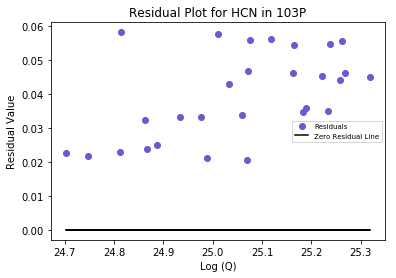

In [54]:
q_pred_hcn = list(hcn['log(Q)']) # literature production rates

res_hcn = (np.array(q_pred_hcn)) - (np.array(q_found_hcn)) # calculate residuals

print("The Residuals between sbpy results and literature are:\n {}".format(np.round(res_hcn,3))) 

z = np.zeros(len(res_hcn)) # create 'zero' line

plt.plot(q_pred_hcn, res_hcn, 'o', color='slateblue', label='Residuals') # plot residuals
plt.plot(q_pred_hcn, z, 'k', label='Zero Residual Line')
plt.xlabel('Log (Q)')
plt.ylabel('Residual Value')
plt.legend(loc='center right', fontsize='x-small')
plt.title('Residual Plot for HCN in {}'.format(target))
plt.show()


LTE `from_Drahus` Second Example (User-defined Data):
-------------------------------------------------------------------------------------------------------------

*Load the data file containing values for time of observations, integrated flux, 
and error bars from the literature (Drahus et al. 2012) in order to obtain the 
information needed for the calculation of our production rates*

In [55]:
ch3oh = Table.read('data/CH3OH.csv', format="ascii.csv")

Model parameters needed, all values are taken directly from the literature (Drahus et al. 2012). See [documentation](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#production-rate-calculations) for more information on the parameter values

In [56]:
temp_estimate = 47. * u.K 

target = '103P' 

vgas = 0.8 * u.km / u.s 

aper = 30 * u.m  # telescope aperture

b = 1.13  # intrinsic antenna value

mol_tag = 32003 # JPLSpec unique identifier

transition_freq = (157.178987 * u.GHz).to('MHz')


*In this example we will show how users can define and store their own molecular data in a phys object.
See the other two examples for the use of from_jplspec to obtain the molecular data necessary for
production rate calculations. For more information on the molecular parameters needed see both `activity.productionrate` [module](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#production-rate-calculations) and `astroquery.jplspec` [module](https://astroquery.readthedocs.io/en/latest/jplspec/jplspec.html) documentation*

In [57]:
lgint300 = 7.4336139*10**(-5) * u.MHz * u.nm * u.nm # integrated line intensity (300 K)

part300 = 9473.271845042498 # partition function (300 K)

partition = 308.5479509730844 # paritition function

gu = 11.0 # Upper state degeneracy

energy_J = 6.61822698*10**(-22) * u.J # Upper level energy

elo_J = 5.57674801*10**(-22) * u.J # Lower level energy

df = 3 # degrees of freedom

quantities = [transition_freq, temp_estimate, lgint300, part300, partition, gu, energy_J,
              elo_J, df, mol_tag] # define list

names = ('Transition frequency',
         'Temperature',
         'Integrated line intensity at 300 K',
         'Partition function at 300 K',
         'Partition function at designated temperature',
         'Upper state degeneracy',
         'Upper level energy in Joules',
         'Lower level energy in Joules',
         'Degrees of freedom', 'Molecule Identifier') # define field names

mol_data = Phys.from_array(quantities, names) # build the phys object


Obtaining the Einstein Coefficient, and integrated line intensity at a given temperature from the molecular data,
as explained in the first example. The next example will show how to use a user-defined Einstein Coefficient.

In [58]:
intl = intensity_conversion(mol_data) # integrated line intensity

mol_data.add_column([intl.value] * intl.unit,
                    name='Integrated line intensity at desired temp') # store value

au = einstein_coeff(mol_data) # obtain Einstein Coefficient

mol_data.add_column([au.value] * au.unit, name='eincoeff') # store value

12

In [59]:
lte = LTE() # initialize LTE class

q_found_ch3oh = [] # define empty list

for i in range(0, 20):

    time = Time(ch3oh['Time'][i], format='iso') # build astropy.time object
    
    integrated_flux = ch3oh['T_B'][i] * u.K * u.km / u.s # integrated flux 
    
    ephemobj = Ephem.from_horizons(target, epochs=time.jd, id_type='id') # create ephem object

    q = lte.from_Drahus(integrated_flux, mol_data, ephemobj, vgas, aper, b=b) # calculate production rate

    q = np.log10(q.value)

    q_found_ch3oh.append(q) # append production rate

print("The Resulting Production Rates for CH3OH in {} using Drahus et al. 2012 model are:\n {}".format(target, np.round(q_found_ch3oh,3))) 

The Resulting Production Rates for CH3OH in 103P using Drahus et al. 2012 model are:
 [26.445 26.573 26.563 26.593 26.597 26.491 26.48  26.553 26.504 26.482
 26.463 26.423 26.354 26.477 26.349 26.399 26.31  26.325 26.401 26.556]


Calculate the residuals:

The Residuals between sbpy results and literature are:
 [0.058 0.058 0.056 0.056 0.056 0.055 0.054 0.047 0.046 0.046 0.045 0.045
 0.044 0.043 0.036 0.035 0.035 0.034 0.033 0.033 0.032 0.025 0.024 0.023
 0.023 0.022 0.021 0.021]


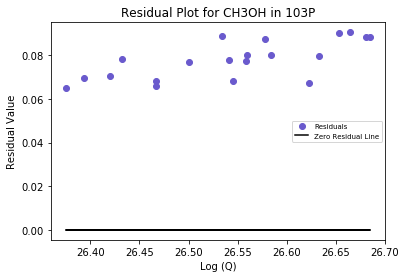

In [60]:
q_pred_ch3oh = list(ch3oh['log(Q)']) # literature production rates

res_ch3oh = (np.array(q_pred_ch3oh)) - (np.array(q_found_ch3oh)) # residuals

print("The Residuals between sbpy results and literature are:\n {}".format(np.round(res_hcn,3))) 

z = np.zeros(len(res_ch3oh)) # create 'zero' line

plt.plot(q_pred_ch3oh, res_ch3oh, 'o', color='slateblue', label='Residuals') # plot
plt.plot(q_pred_ch3oh, z, 'k', label='Zero Residual Line')
plt.xlabel('Log (Q)')
plt.ylabel('Residual Value')
plt.legend(loc='center right', fontsize='x-small')
plt.title('Residual Plot for CH3OH in {}'.format(target))
plt.show()


Calculating Production Rate using `sbpy.activity.gas` Haser model
===================================
____________________________________________________________________________________________________________________

Another model included in the module is based off of the model in the following literature:

> [Haser 1957, Bulletin de la Societe Royale des Sciences de Liege 43, 740.
> Newburn and Johnson 1978, Icarus 35, 360-368.](https://catalog.hathitrust.org/Record/004056063)

This model takes in an initial guess for the production rate, and uses the [`sbpy.activity.Haser`](https://sbpy.readthedocs.io/en/latest/api/sbpy.activity.Haser.html#sbpy.activity.Haser) class instance to obtain a final value. The LTE production rate function `from_Haser` obtains a total number of molecules from `sbpy.activity.Haser` based on a first guess of the production rate (this is where `from_Drahus` comes in handy). Then the function takes a total number of molecules given by the user, and uses a ratio relationship to obtain the optimized production rate: 

$$Q = Q_{guess} \frac{totalnum_{from \: user}}{totalnum_{from \: guess}}$$

The user can either define their chosen total number of molecules, or they can calculate it from their data or JPLSpec data using `sbpy.activity.total_number_nocd`, which is a calculation based on **eq. 10** from:

> [Bockelee-Morvan et al. 2004, Comets II, University of Arizona Press, Tucson, 745 pp., p.391-423](https://ui.adsabs.harvard.edu/#abs/2004come.book..391B)

The literature used for this example is:

> [Wierzchos, K. & M. Womack 2018, C/2016 R2 (PANSTARRS): A Comet Rich in CO and Depleted in HCN, AJ, 156:34](https://arxiv.org/pdf/1805.06918.pdf)

____________________________________________________________________________________________________________________

*Load the data file containing values for time of observations, integrated flux, 
and error bars from the literature (Wierzchos and Womack 2018) in order to obtain the 
information needed for the calculation of our production rates*

In [61]:
co = Table.read(('data/CO.csv'), format="ascii.csv")

*Model parameters needed, all values are taken directly from the literature.
In this example the molecule identifier will be inputted as a regular expression. 
Regular expressions for mol_tag can be used but the user must be careful not to provide
an ambiguous regular expression. One good thing to remember is that anything between symbols '^' and '\\$'
will be matched exactly, therefore you can avoid an ambiguity error by writing your molecule name as such:
'^name\\$'. A perfect example of this is with the molecule in this example 'CO', simply writing mol_tag = 'CO'
will produce an ambiguity error because it will match CO, CO2, etc. therefore, it is necessary to 
restrict our molecule name regex to '^CO\\$' as presented below.*

In [62]:
transition_freq = (230.538 * u.GHz).to('MHz')

aper = 10 * u.m # aperture

mol_tag = '^CO$' # regex molecule identifier

temp_estimate = 25. * u.K 

vgas = 0.5 * u.km / u.s

target = 'C/2016 R2'

b = 0.74 # intrinsic antenna value

Obtaining molecular data from the JPL Molecular Spectroscopy Catalog using `sbpy.data.phys`. 
See documentation for a detailed breakdown of the resulting object and the values stored in the object.

In [63]:
mol_data = Phys.from_jplspec(temp_estimate, transition_freq, mol_tag) # molecular data from JPLSpec

intl = intensity_conversion(mol_data) # calculate line intensity

mol_data.add_column([intl.value] * intl.unit,
                    name='Integrated line intensity at desired temp') # store value

11

*Obtaining the Einstein Coefficient. In this example, we will obtain our Einstein Coefficient from
LAMDA catalog and append it to our molecular data Phys object. In the previous exammples we have been calculating it through sbpy/JPLSpec. It is possible that your transition frequency values may not exactly match the LAMDA catalog to the 4th significant figure, especially if you're using JPLSpec. Therefore, we recommend when using this method
that you match your transition frequency with the LAMDA value over the JPLSpec value, since from_jplspec is
designed to pick the closest transition frequency within a range of 1 GHz, whereas LAMDA will expect the
exact value found in their catalog.*

In [64]:
from astroquery.lamda import Lamda

mol_name = 'CO' # LAMDA molecule name

lam_search = Lamda.query(mol=mol_name.lower()) # LAMDA Query

lam_result = lam_search[1] # outputs CO table

lam_found = lam_result[lam_result['Frequency'] == transition_freq.to('GHz').value] # parse results at frequency

au_cat = lam_found['EinsteinA'] # get Einstein Coefficient

au_cat = au_cat.data[0] # get value of coefficient

au = au_cat / u.s # define the unit

mol_data.add_column([au.value] * au.unit, name='eincoeff') # store einstein coefficient

12

Initialize the `spby.activity.Haser` model in order to perform our production rate calculations. 
`Q_estimate` first guess for the production rate was obtained running `from_Drahus` for the same data set before doing this example

In [65]:
Q_estimate = 3.594*10**(28) / u.s 

parent = photo_timescale('CO') * vgas # parent photodissociation rate

coma = Haser(Q_estimate, vgas, parent) # initializing the model with an estimate 

*Since our data file contains 6 different data points of observation times and integrated flux, we can
calculate production rates for all of these 6 data points using a python for loop.*

*The `beta_factor` function is only necessary if the user will be using the `total_number_nocd` function, if 
the user chooses to define their total number of molecules by any other means, or calculate it by any other 
means then the `beta_factor` is not a necessary calculation. In order to understand how to user-define the 
total number, refer to previous sections in which user-defined values are appended to the `mol_data` phys object.*

**IMPORTANT: Because we are using a for loop, and some of the values that should be appended to the `mol_data`
phys object are calculated within the loop itself, we must initialize our columns within the phys object
BEFORE performing the loop. This is because you cannot iteratively redefine the same column of data within a 
phys object, but you CAN change the value of an already defined column as many times as you want.
Since our 'beta' and 'total number' values vary with every iteration,
and since our production rate needs both these values within the loop, we must simply change the value of our
already defined columns for beta and total number everytime we iterate. Keep in mind when you initialize
the column you must initialize it with the correct units and correct type (float, int, str)**

In [66]:
mol_data.add_column([1.] * u.AU * u.AU * u.s, name='beta') # initialize beta column
mol_data.add_column([1.], name='total_number_nocd') # initialize total number column

q_found_co = [] # define empty list

lte = LTE() # initialize LTE class

for i in range(0, 5):

    time = Time(co['Time'][i], format='iso')
    
    integrated_flux = co['T_B'][i] * u.K * u.km / u.s
    
    ephemobj = Ephem.from_horizons(target, epochs=time.jd)
    
    beta = beta_factor(mol_data, ephemobj) # calculate beta factor
    
    mol_data['beta'] = beta # redefine column value for beta
    
    tnum = total_number_nocd(integrated_flux, mol_data, aper, b) # calculate total number

    mol_data['total_number_nocd'] = tnum # redefine column value for total number

    Q = lte.from_Haser(coma, mol_data, aper=aper) # calculate production rate

    q_found_co.append(np.log10(Q.value)[0]) # append production rate

print("The Resulting Production Rates for CO in {} using Haser model are:\n {}".format(target, np.round(q_found_co,3))) 

The Resulting Production Rates for CO in C/2016 R2 using Haser model are:
 [27.979 28.01  27.968 27.983 27.961]


Calculate residuals:

The Residuals between sbpy results and literature are:
 [0.664 0.653 0.695 0.68  0.702]


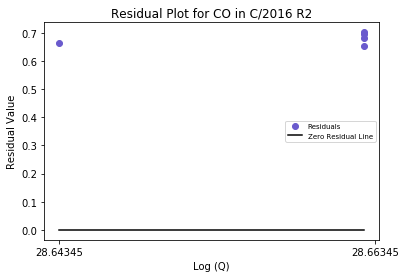

In [67]:
q_pred_co = list(co['log(Q)']) # literature production rates

res_co = (np.array(q_pred_co)) - (np.array(q_found_co)) # residuals

print("The Residuals between sbpy results and literature are:\n {}".format(np.round(res_co,3))) 

z = np.zeros(len(res_co)) # create 'zero' line

plt.plot(q_pred_co, res_co, 'o', color='slateblue', label='Residuals') # plot
plt.plot(q_pred_co, z, 'k', label='Zero Residual Line')
plt.xlabel('Log (Q)')
plt.ylabel('Residual Value')
plt.legend(loc='center right', fontsize='x-small')
plt.title('Residual Plot for CO in {}'.format(target))
plt.xticks(np.arange(min(q_pred_co), max(q_pred_co)+0.003, 0.02))
plt.show()


Helpful Links
=======
___________________________________________

- [LAMDA Queries with astroquery](https://astroquery.readthedocs.io/en/latest/lamda/lamda.html)
- [JPLSpec Queries with astroquery](https://astroquery.readthedocs.io/en/latest/jplspec/jplspec.html)
- [sbpy Activity Haser Class](https://sbpy.readthedocs.io/en/latest/api/sbpy.activity.Haser.html#sbpy.activity.Haser)
- [sbpy Ephem data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-ephem)
- [sbpy Phys data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-phys)
- [sbpy data class alternative field names](https://sbpy.readthedocs.io/en/latest/sbpy/data/fieldnames.html#list-of-alternative-field-names)
- [sbpy citation (please cite our work)](http://joss.theoj.org/papers/10.21105/joss.01426)